### AI-04 Assignment 1

#### Import libraries  

In [153]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### Import my libraries

In [154]:
my_libs_dir = '../'
if not my_libs_dir in sys.path:
    sys.path.append(my_libs_dir)  # add the path to my_lib directory 

# The following lines are needed to auto-reload my library file
# Without these lines, my library file is read only once and
# modifications of my library file are not reflected.
%load_ext autoreload
%autoreload 1
%aimport my_libs.linear_reg
# import from my library file
from my_libs.linear_reg import step_aic_forward, calc_vifs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Parameters

In [155]:
%config InlineBackend.figure_formats = {'png', 'retina'} #high-reso images
font = {'family' : 'Yu Mincho'}
matplotlib.rc('font', **font)

# To show all rows and columns in the results 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

#### Step 1. Collect possible explanatory variables  
目的変数に影響を与えていそうな要因は、可能な限り網羅的に説明変数に取り入れる。  

##### Check & read CSV file, replace column labels if needed, etc.  
encoding='shift-jis' may be needed.    
CSVファイルをチェックしてから読み込む。必要に応じて列ラベルを変更。  
CSVファイルの漢字コードがShift-JISの場合は encoding='shift-jis' が必要。　　

In [156]:
csv_in = 'winequality-red_modified-utf8.txt'
df_all = pd.read_csv(csv_in, delimiter='\s+', skiprows=13, header=0)
print(df_all.shape)
print(df_all.info())
display(df_all.head())

(1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed_acidity           1599 non-null float64
volatile_acidity        1599 non-null float64
citric_acid             1599 non-null float64
residual_sugar          1599 non-null float64
chlorides               1598 non-null float64
free_sulfur_dioxide     1599 non-null float64
total_sulfur_dioxide    1599 non-null float64
density                 1597 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9        NaN   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0      NaN  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0      NaN  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

##### Check numerical / category variables if needed  
数値列・カテゴリー列の様子をみる  

In [157]:
display(df_all.describe())
#display(df_all.describe(exclude='number'))  # no category value columns

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  1598.000000          1599.000000           1599.000000  1597.000000   
mean      0.087474            15.874922             46.467792     0.996746   
std       0.047079            10.460157             32.895324     0.001888   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997830   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

##### See rows including missing data  
欠損値を含む行を表示してみる  

In [158]:
display(df_all[df_all.isnull().any(axis=1)])

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
1            7.8              0.88         0.00             2.6      0.098   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9        NaN   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
1                 25.0                  67.0      NaN  3.20       0.68   
3                 17.0                  60.0      NaN  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
1      9.8        5  
3      9.8        6  
4      9.4        5

##### Delete rows including missing data  
欠損値を含む行を削除する  

In [159]:
df_all = df_all.dropna().reset_index(drop=True)
print(df_all.shape)
display(df_all.head())

(1596, 12)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.76         0.04             2.3      0.092   
2            7.4              0.66         0.00             1.8      0.075   
3            7.9              0.60         0.06             1.6      0.069   
4            7.3              0.65         0.00             1.2      0.065   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 15.0                  54.0   0.9970  3.26       0.65   
2                 13.0                  40.0   0.9978  3.51       0.56   
3                 15.0                  59.0   0.9964  3.30       0.46   
4                 15.0                  21.0   0.9946  3.39       0.47   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.4        5  
3      9.4        5  
4     10.0        7

**Answer 1: #data = 1596**

##### Separate explanatory variables and objective variable  
説明変数と目的変数を分ける  

In [160]:
X_all_org = df_all.loc[:, 'fixed_acidity':'alcohol']  # explanatory variables
y = df_all['quality']  # objective variable
print('X_all_org:', X_all_org.shape)
display(X_all_org.head())
print('y:', y.shape)
print(y.head())

X_all_org: (1596, 11)


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.76         0.04             2.3      0.092   
2            7.4              0.66         0.00             1.8      0.075   
3            7.9              0.60         0.06             1.6      0.069   
4            7.3              0.65         0.00             1.2      0.065   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 15.0                  54.0   0.9970  3.26       0.65   
2                 13.0                  40.0   0.9978  3.51       0.56   
3                 15.0                  59.0   0.9964  3.30       0.46   
4                 15.0                  21.0   0.9946  3.39       0.47   

   alcohol  
0      9.4  
1      9.8  
2      9.4  
3      9.4  
4     10.0

y: (1596,)
0    5
1    5
2    5
3    5
4    7
Name: quality, dtype: int64


##### Apply get_dummies()  
ダミー変数化  

In [161]:
# get_dummies is not needed
X_all = X_all_org.copy()

#X_all = pd.get_dummies(X_all_org, drop_first=True)
#print('X_all:', X_all.shape)
#display(X_all.head())

#### Step 2. Scatter plot and correlation coefficients between all combination of explanatory variables  
変数間の総当たり散布図を描画。相関係数も算出しておく  

##### all by all Pearson correlation coefficients;  
総当たりのPearson相関係数  

In [162]:
corr_all = X_all.corr(method='pearson')
display(corr_all)

fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.254796     0.671376   
volatile_acidity          -0.254796          1.000000    -0.550864   
citric_acid                0.671376         -0.550864     1.000000   
residual_sugar             0.115231          0.001749     0.143933   
chlorides                  0.094037          0.061071     0.204452   
free_sulfur_dioxide       -0.154094         -0.011231    -0.060859   
total_sulfur_dioxide      -0.113752          0.076463     0.035440   
density                    0.668356          0.022282     0.365623   
pH                        -0.683007          0.234924    -0.542063   
sulphates                  0.183527         -0.261792     0.313457   
alcohol                   -0.061580         -0.202022     0.109363   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity               0.115231   0.094037            -0.154094   
volatile_acidity            0.001749   0.061071            -0.011231   
citric_acid                 0.143933   0.204452            -0.060859   
residual_sugar              1.000000   0.055469             0.187006   
chlorides                   0.055469   1.000000             0.005389   
free_sulfur_dioxide         0.187006   0.005389             1.000000   
total_sulfur_dioxide        0.203091   0.047337             0.667541   
density                     0.355759   0.200882            -0.021855   
pH                         -0.085640  -0.265166             0.071304   
sulphates                   0.005230   0.371164             0.051475   
alcohol                     0.041679  -0.221426            -0.069386   

                      total_sulfur_dioxide   density        pH  sulphates  \
fixed_acidity                    -0.113752  0.668356 -0.683007   0.183527   
volatile_acidity                  0.076463  0.022282  0.234924  -0.261792   
citric_acid                       0.035440  0.365623 -0.542063   0.313457   
residual_sugar                    0.203091  0.355759 -0.085640   0.005230   
chlorides                         0.047337  0.200882 -0.265166   0.371164   
free_sulfur_dioxide               0.667541 -0.021855  0.071304   0.051475   
total_sulfur_dioxide              1.000000  0.071252 -0.065735   0.042895   
density                           0.071252  1.000000 -0.342146   0.148960   
pH                               -0.065735 -0.342146  1.000000  -0.196633   
sulphates                         0.042895  0.148960 -0.196633   1.000000   
alcohol                          -0.205651 -0.495957  0.206091   0.093188   

                       alcohol  
fixed_acidity        -0.061580  
volatile_acidity     -0.202022  
citric_acid           0.109363  
residual_sugar        0.041679  
chlorides            -0.221426  
free_sulfur_dioxide  -0.069386  
total_sulfur_dioxide -0.205651  
density              -0.495957  
pH                    0.206091  
sulphates             0.093188  
alcohol               1.000000

##### Pickup explanatory variable pairs with large absolute value of correlation coefficient;  
相関係数の絶対値が大きい説明変数ペアの出力   

In [163]:
th_corr = 0.3
keep = np.triu(np.ones(corr_all.shape), k=1).astype('bool').flatten()
triu = corr_all.stack()[keep]
triu_sorted = triu[ np.abs(triu).sort_values(ascending=False).index ]
print(triu_sorted[ (triu_sorted < -th_corr) | (triu_sorted > th_corr) ])

fixed_acidity        pH                     -0.683007
                     citric_acid             0.671376
                     density                 0.668356
free_sulfur_dioxide  total_sulfur_dioxide    0.667541
volatile_acidity     citric_acid            -0.550864
citric_acid          pH                     -0.542063
density              alcohol                -0.495957
chlorides            sulphates               0.371164
citric_acid          density                 0.365623
residual_sugar       density                 0.355759
density              pH                     -0.342146
citric_acid          sulphates               0.313457
dtype: float64


##### all by all scatter plots of explanatory variables;  
変数間の総当たり散布図  

##### if you want to use seaborn instead of matplotlib

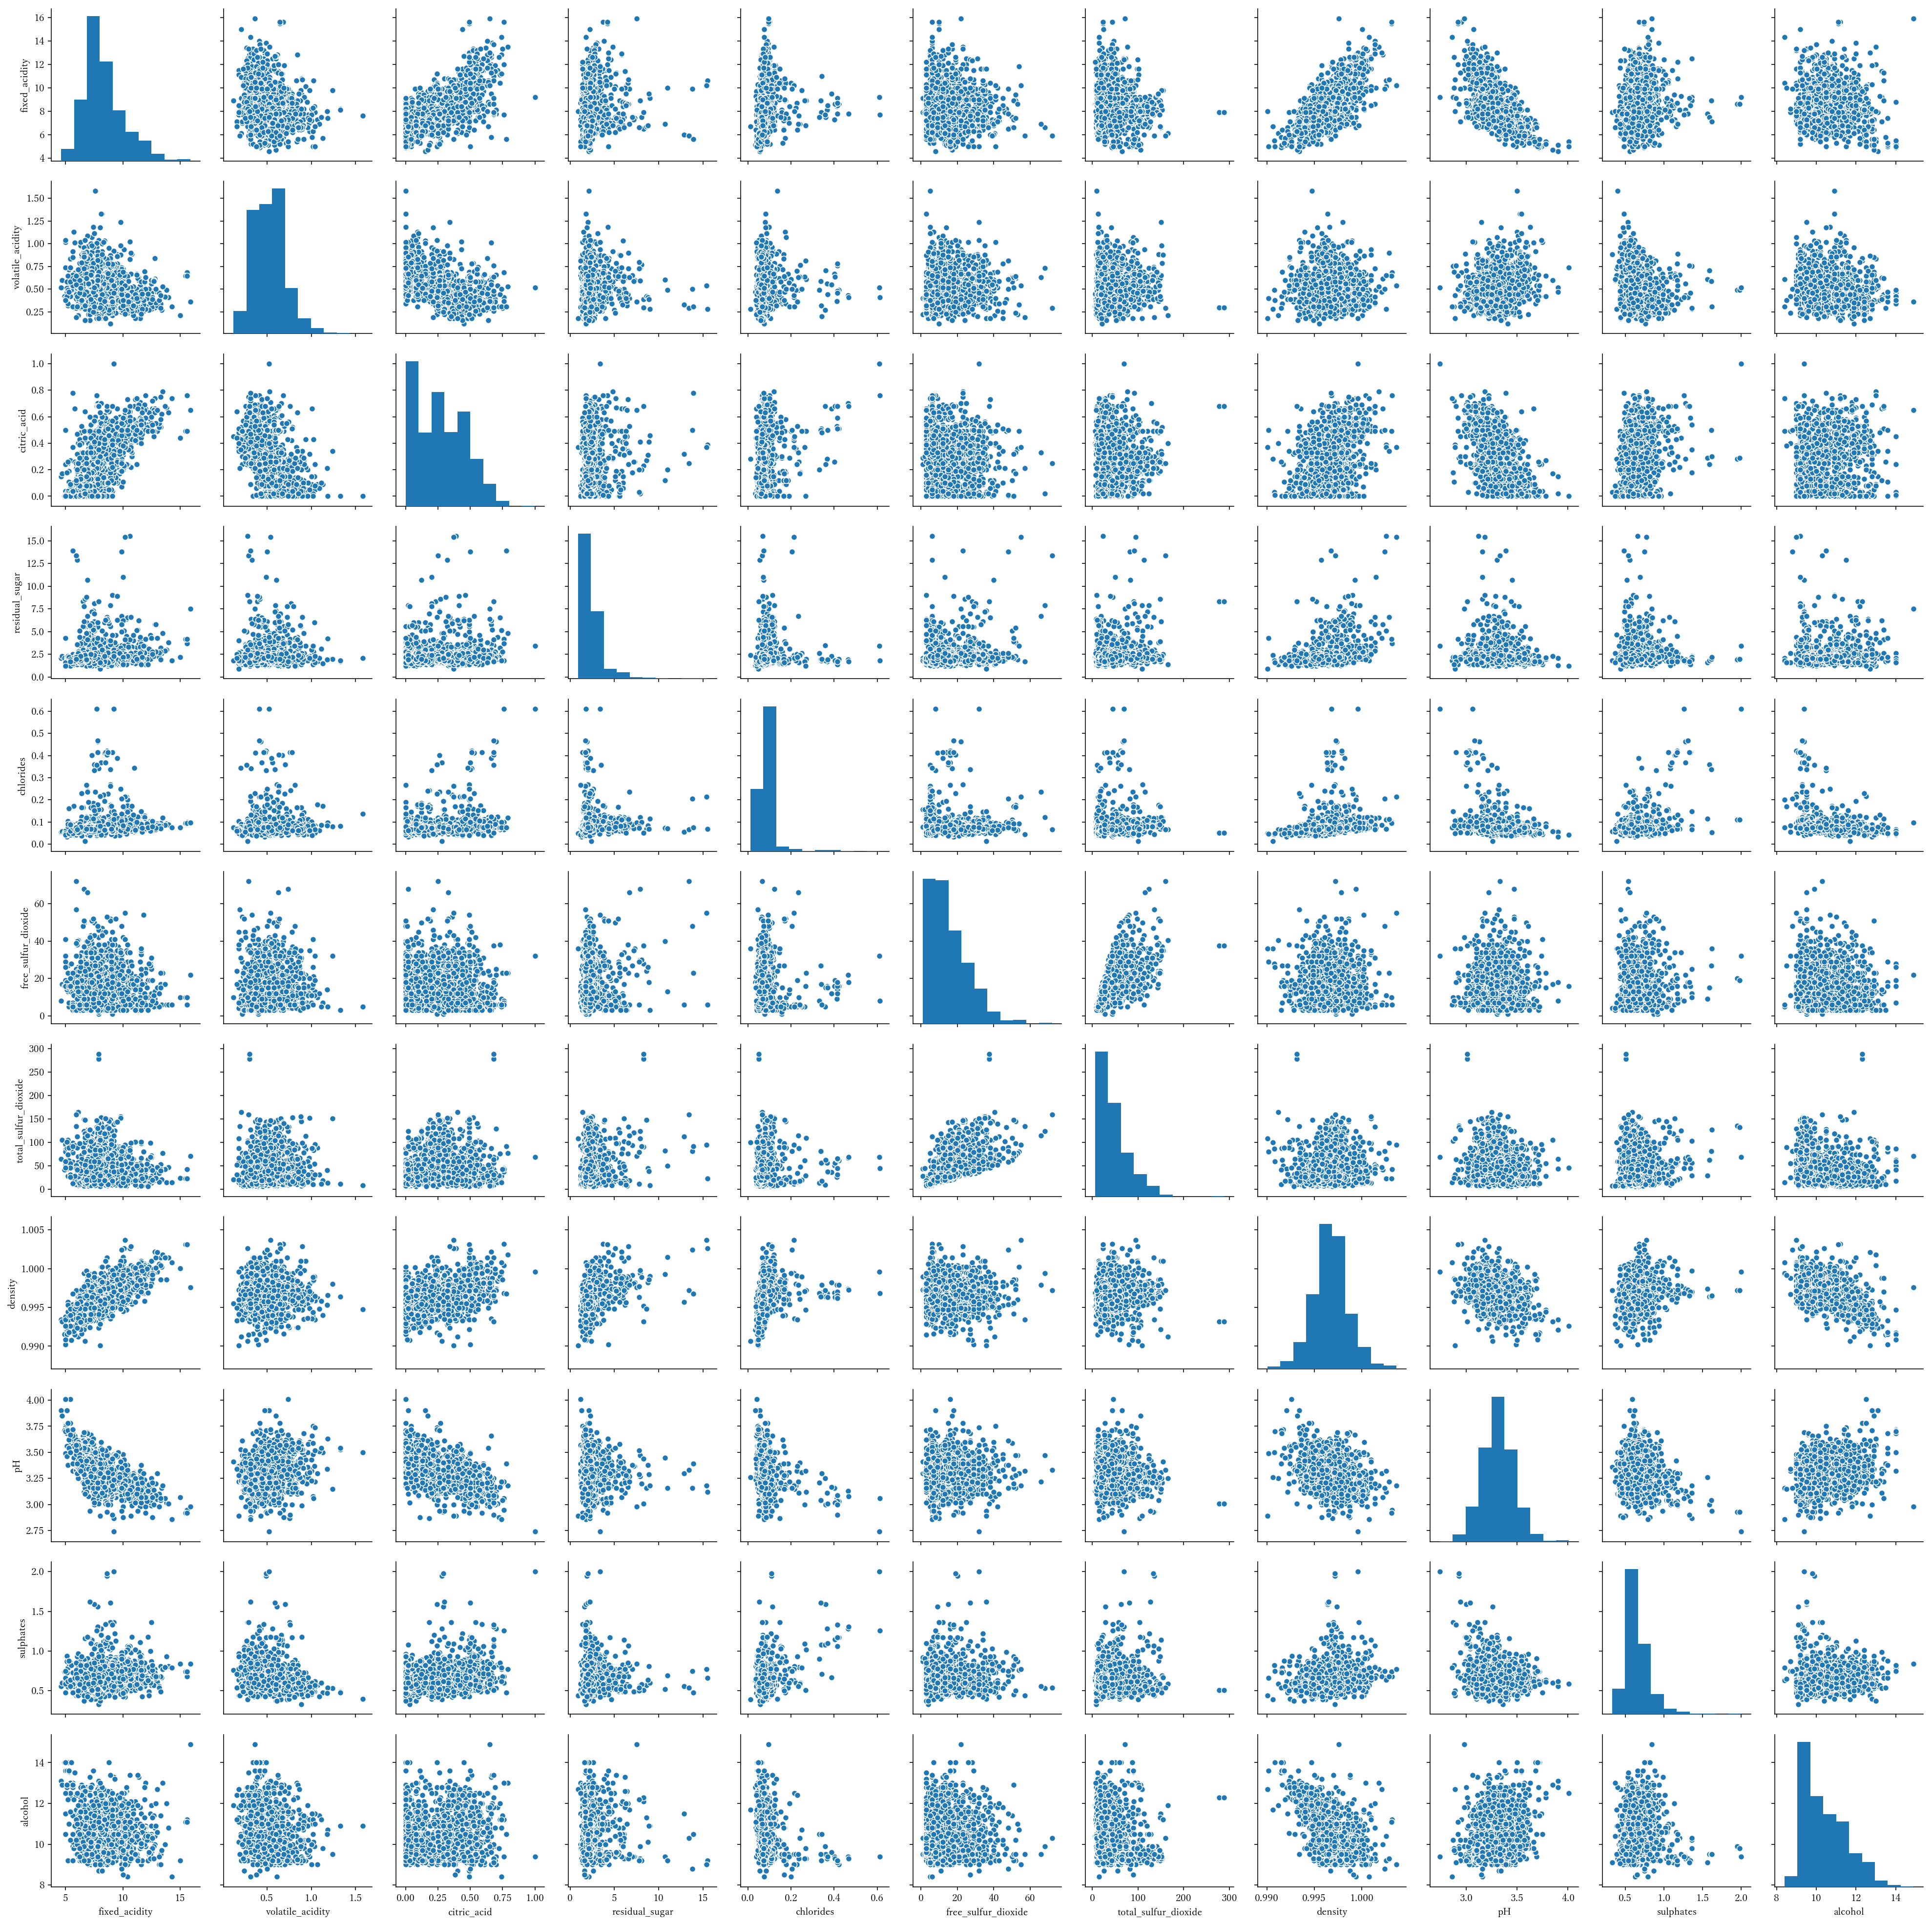

In [164]:
sns.pairplot(X_all)
plt.show()

##### Heatmap  
Heatmapを描いてもよい  

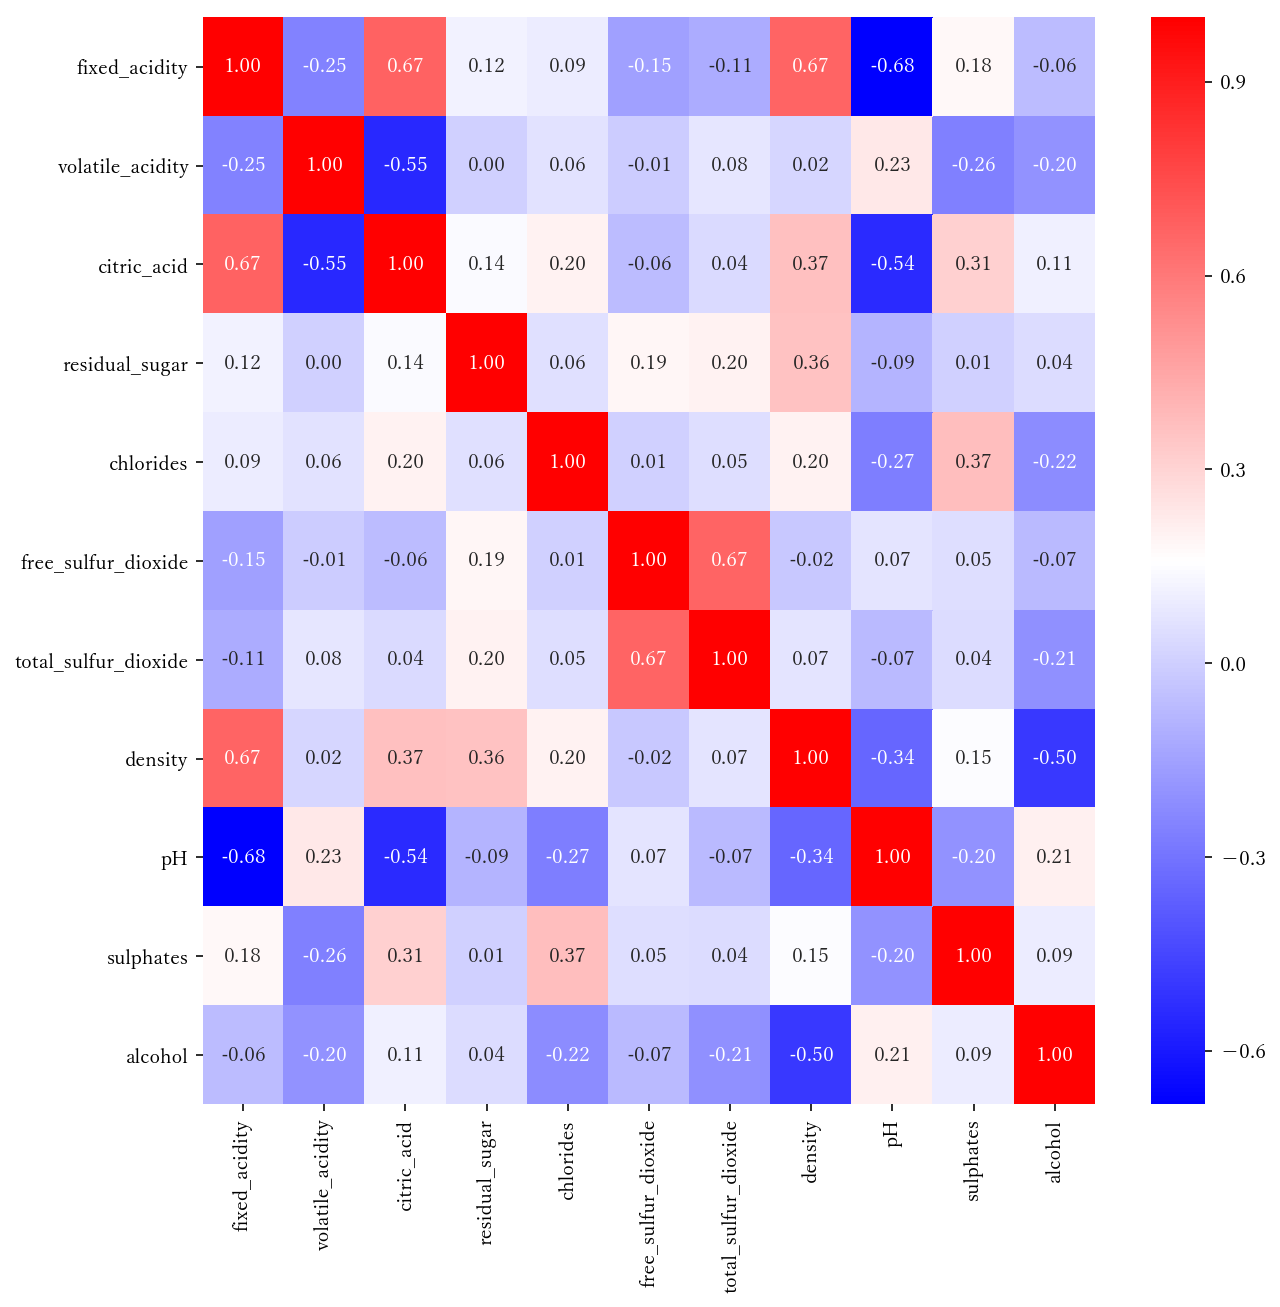

In [165]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_all,annot=True,fmt='.2f',cmap='bwr')
plt.show()

#### Step 3. MLR calculation using all variables  
全説明変数を用いて、標準化なしで線形重回帰分析  

In [166]:
X_all_c = sm.add_constant(X_all)
model = sm.OLS(y, X_all_c)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.03
Date:                Wed, 24 Apr 2019   Prob (F-statistic):          6.17e-145
Time:                        19:33:05   Log-Likelihood:                -1567.6
No. Observations:                1596   AIC:                             3159.
Df Residuals:                    1584   BIC:                             3224.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.6728 

In [167]:
#help(results)
#print(dir(results))  # To know all methods/attributes of an object

#### Step 4. Check R2 and Adjusted R2 to see whether MLR is appropriate for this data  
決定係数や自由度調整済み決定係数をみて、そもそも線形モデルの当てはめが妥当かどうかを判断  

In [168]:
print('R2:', results.rsquared)
print('Adj R2:', results.rsquared_adj)

R2: 0.36008321392086806
Adj R2: 0.3556393473508741


**Answer 2: R2 = 0.360**

Not so good ... but move on to the next step.  

#### Step 5. Stat. test for MLR equation  
重回帰式の検定 (求めた重回帰式は目的変数を説明している？)  

In [169]:
print('p-values (F-statistic)', results.f_pvalue)

p-values (F-statistic) 6.168748635713252e-145


Very small p-value, so this MLR equation is considered to be significant.  

#### Step 6. Standardization of variables  
Compare coefficients for explanatory variables  
全説明変数と目的変数を標準化して線形重回帰分析  
標準化偏回帰係数を比較　　

In [170]:
# NOTE: after scaling, X_scaled and Y_scaled are ndarray, not DataFrame.
X_scaled = preprocessing.scale(X_all)
y_scaled = preprocessing.scale(y)
model = sm.OLS(y_scaled, X_scaled)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.08
Date:                Wed, 24 Apr 2019   Prob (F-statistic):          4.95e-145
Time:                        19:33:05   Log-Likelihood:                -1908.4
No. Observations:                1596   AIC:                             3839.
Df Residuals:                    1585   BIC:                             3898.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0528      0.056      0.942      0.3

C:\Users\shugo\Miniconda3\envs\ds2019\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


#### Step 7.　Feature selection  
変数選択  

In [171]:
# NOTE: make DataFrames corresponding to X_scaled and y_scaled.
dfX_scaled = pd.DataFrame(X_scaled, columns=X_all.columns)
dfy_scaled = pd.Series(y_scaled, name=y.name)
exog = list(dfX_scaled.columns)  # Initial set = all explanatory variables
endog = [dfy_scaled.name]  # Objective variables
df_scaled = pd.concat([dfX_scaled, dfy_scaled], axis=1)

##### by forward selection method based on AIC  
変数増加法による変数選択  

In [172]:
results_aic=step_aic_forward(smf.ols, exog, endog, data=df_scaled)

AIC: 4531.252, formula: quality ~ 1
AIC: 4123.148, formula: quality ~ alcohol
AIC: 4483.646, formula: quality ~ density
AIC: 4506.508, formula: quality ~ chlorides
AIC: 4528.011, formula: quality ~ pH
AIC: 4450.253, formula: quality ~ citric_acid
AIC: 4428.999, formula: quality ~ sulphates
AIC: 4529.172, formula: quality ~ free_sulfur_dioxide
AIC: 4270.337, formula: quality ~ volatile_acidity
AIC: 4477.538, formula: quality ~ total_sulfur_dioxide
AIC: 4532.954, formula: quality ~ residual_sugar
AIC: 4508.780, formula: quality ~ fixed_acidity
AIC: 4114.882, formula: quality ~ alcohol + density
AIC: 4123.949, formula: quality ~ alcohol + chlorides
AIC: 4072.263, formula: quality ~ alcohol + pH
AIC: 4061.342, formula: quality ~ alcohol + citric_acid
AIC: 4033.266, formula: quality ~ alcohol + sulphates
AIC: 4124.514, formula: quality ~ alcohol + free_sulfur_dioxide
AIC: 3928.074, formula: quality ~ alcohol + volatile_acidity
AIC: 4108.632, formula: quality ~ alcohol + total_sulfur_dioxide

In [173]:
print(results_aic.aic)
print(results_aic.model.exog_names)
print(results_aic.model.endog_names)

3835.4763012244853
['Intercept', 'alcohol', 'volatile_acidity', 'sulphates', 'total_sulfur_dioxide', 'chlorides', 'pH', 'free_sulfur_dioxide']
quality


#### Step 8. Check of multicolinearity (VIF checkup)  
マルチコのチェック  

- Iteration of Variable selection (selected_cols) <-> Check VIF  
until all VIFs < 10.  
- NOTE: standardization of variables does not affect the results   

Format of results of statsmodels:
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html  

In [174]:
endogs = results_aic.model.endog_names
exogs = results_aic.model.exog_names.copy()
exogs.remove('Intercept')
#print(exogs)  # debug
X_c = sm.add_constant(X_all[exogs])
vifs = calc_vifs(X_c, y)
display(vifs)

C:\Users\shugo\Miniconda3\envs\ds2019\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


VIF
const                 618.539992
alcohol                 1.220248
volatile_acidity        1.242579
sulphates               1.322258
total_sulfur_dioxide    1.943518
chlorides               1.333407
pH                      1.255038
free_sulfur_dioxide     1.882888

How to eliminate multicolinearity is case by case.  
Here we simply delete three explanatory variables with high VIF.  

In [175]:
# all VIFs < 10, so removal of variables is not needed
#exogs.remove('w_all')
#exogs.remove('w_meat')
#exogs.remove('w_shell')
#print(exogs)  # debug
#X_c = sm.add_constant(X_all[exogs])
#vifs = calc_vifs(X_c, y)
#display(vifs)

For all explantory variables, VIF < 10, so we can go forward.  

#### Step 9. Estimate the magnitude of the influence of each explanatory variable on the objective variable  
最終的に得られた標準化偏回帰係数から、各説明変数の目的変数に対する影響の大きさがわかる  

In [176]:
X_final_scaled = dfX_scaled[exogs]
model_final_scaled = sm.OLS(y_scaled, X_final_scaled)
results_final_scaled = model_final_scaled.fit()
print(results_final_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     127.1
Date:                Wed, 24 Apr 2019   Prob (F-statistic):          1.48e-148
Time:                        19:33:06   Log-Likelihood:                -1909.7
No. Observations:                1596   AIC:                             3833.
Df Residuals:                    1589   BIC:                             3871.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
alcohol                  0.3819 

In [177]:
print(results_final_scaled.params)

alcohol                 0.381874
volatile_acidity       -0.223534
sulphates               0.185601
total_sulfur_dioxide   -0.142075
chlorides              -0.117664
pH                     -0.092192
free_sulfur_dioxide     0.065957
dtype: float64


The order of strengths of influences on objective variables:  
**Answer 3: alcohol (positive) > volatile_acidity (negative) > sulphates (positive) > total_sulfur_dioxide (negative)
      > chlorides (negative) > pH ( negative) > free_sulfur_dioxide (positive)**  
（これが、目的変数qualityに対する各説明変数の影響の大きさ順）

#### Step 10. Stat. test for MLR equation  
重回帰式の検定 (求めた重回帰式は目的変数を説明している？)  

In [178]:
print('p-values (F-statistic)', results_final_scaled.f_pvalue)

p-values (F-statistic) 1.483927135893033e-148


Very small p-value, so this MLR equation is considered to be significant.  

#### Step 11. MLR calculation using selected explanatory variables  
選択された説明変数を用いて、標準化なしで線形重回帰分析 

In [179]:
X_final_c = sm.add_constant(X_all[exogs])
model_final = sm.OLS(y, X_final_c)
results_final = model_final.fit()
print(results_final.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     127.1
Date:                Wed, 24 Apr 2019   Prob (F-statistic):          1.85e-148
Time:                        19:33:06   Log-Likelihood:                -1568.9
No. Observations:                1596   AIC:                             3154.
Df Residuals:                    1588   BIC:                             3197.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.4260 

#### Step 12. Check R2 and Adjusted R2  
決定係数や自由度調整済み決定係数をみて、線形モデルの当てはまりの良さをチェック  

In [180]:
print('R2:', results_final.rsquared)
print('Adj R2:', results_final.rsquared_adj)

R2: 0.3589972226304373
Adj R2: 0.3561716436369947


The fit of "the best model" is not good ...

#### Step 13. partial regression coefficients  
最終的に得られた偏回帰係数から、「各説明変数が1増えたときの目的変数の増分」がわかる。  

In [181]:
print(results_final.params)

const                   4.426027
alcohol                 0.289401
volatile_acidity       -1.009819
sulphates               0.884003
total_sulfur_dioxide   -0.003487
chlorides              -2.018132
pH                     -0.482495
free_sulfur_dioxide     0.005091
dtype: float64


Coefficients of MLR;  
Increment of objective variable when corresponding variable is increased by 1  
and other variables are not changed  

#### Obtained best model:
**Answer 5: quality $\sim$ 4.426 + 0.289 * alcohol + (-1.010) * volatile_acidity + 0.884 * sulphates +  
    (-0.003) * total_sulfur_dioxide + (-2.018) * chlorides + (-0.482) * pH + (0.005) * free_sulfur_dioxide**  
**Answer 6: -2.018**